### Previous work (scroll down and start below)

In [343]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
def debug(i, j, k, K, n, t, v):
    first = "i: {}\tj: {}\tn: {}\tT(k,j,n): {}\tV(k): {}".format(i, j, n, t, v)
    others = "T(k,j,n): {}\tV(k): {}".format(t, v)
    if(k == 0):
        print(first, end="")
    else:
        print(others, end="")
    if(k != K):
        print(" +\t", end="")
    else:
        print("")

def value_iteration(states, actions, T, rewards, gamma, beta, values=[], verbose=False):
    """
        @brief: implements Bellman's equation to assign the max expected state values
        
        @input:
            states: a list of states (length is j), type should be string if verbose=True i.e. ["s1", "s2", "living room" ... "etc"]
            actions: a list of actions (length is n), type should be string if verbose=True i.e. ["a1", "a2", "take picture" ... "etc"]
            T: a jxjxn matrix of transition probabilities P(Sj | Si, An) for all Sj, Si, and An, j=i is valid (self transitions)
            rewards: an array of length j specifying the reward for each state. The reward value never changes.
            gamma: the discount factor, i.e. how much do we care about future rewards
            beta: the stopping criteria, i.e. minimum amount of improvement between iterations before stopping
            values: [optional] current values of the states, set to the states reward value if not supplied
            verbose: [optional] set to false 
        
        @output:
            values: an array of state values where V(S(i)) = V[i]
            policy: a dictionary mapping states as keys to the best action as values, i.e. policy["some state"] -> "some action"
    """
    if(len(values) == 0):
        values = rewards[:]
    old_values = np.ones(len(rewards))*-999
    #stopping_criteria = .005
    policy = dict.fromkeys(states, "")
    i = 0
    while(abs(sum(values) - sum(old_values)) > beta):
        old_values = values[:]
        for j in range(0, len(states)): # all states in S
            vals = np.zeros(len(actions))
            for n in range(0, len(actions)): # valid actions in Sj
                assert vals[n] == 0
                for k in range(0, len(states)): # reachabe states from Sj
                    vals[n] = vals[n] + T[k][j][n]*values[k]
                    if(verbose):
                        debug(i, j, k, len(states)-1, n, T[k][j][n], values[k])
            values[j] = rewards[j] + gamma * np.amax(vals)
            policy[states[j]] = actions[np.argmax(vals)]
            if(verbose):
                print("Vals: {}".format(vals))
                print("V({0}) = R({0}) + gamma*max({1})".format(j, vals))
                print("V({0}) = {1} + {2}*{3}".format(j, rewards[j], gamma, np.amax(vals)))
                print("V(" + str(j) + "): " + str(values[j]))
        i = i + 1
    print("Stopping criteria met. state values have been permanently assigned.")
    print("V(s1) = {:.2f}\tV(s2) = {:.2f}".format(values[0], values[1]))
    print("R(s1) = {:.2f}\tR(s2) = {:.2f}".format(rewards[0], rewards[1]))
    print("Optimal policy: ")
    for key, value in policy.items():
        print("in state (" + key + ") take action (" + value+ ")")
    return values, policy


### contrived example for understanding value iteration

In [211]:
#### dont change anything in this cell, just comment out if needed.
states = ["s1", "s2"]
actions = ["a1", "a2"]
rewards = [3, -1]

# initialize the values
# possible choices are random, zeros, or set to reward value
values = rewards[:]

# T is a jxjxn matrix of transition probabilities P(Sj | Si, An) for all Sj, Si, and An
# P(s1 | s1, a1) = 0.0
# P(s1 | s1, a2) = 0.5 
# .... 
# P(s2 | s2, a2) = 1.0
# This information must be given (or learned, but that is a different problem)
T = [[[0, .5], [1.0, 0]], [[1.0, .5], [0, 1.0]]]

# the weight factor for how much we care about future rewards
gamma = .5

# the stopping criteria, i.e. if improvement is less than this value then stop
beta = .005
values, policy = value_iteration(states, actions, T, rewards[:], gamma, beta, values=rewards[:], verbose=False)
print(values)
print(policy)

Stopping criteria met. state values have been permanently assigned.
V(s1) = 4.40	V(s2) = 1.20
R(s1) = 3.00	R(s2) = -1.00
Optimal policy: 
in state (s1) take action (a2)
in state (s2) take action (a1)
[4.399061441421509, 1.1995307207107544]
{'s1': 'a2', 's2': 'a1'}


# Start here

### Q-value iteration for prognostics scheduling
#### valid actions are 
    - maintenance 
    - short mission
    - long mission

### 1) function definitions

In [1647]:
def get_actions(state, actions):
    """
        @brief: maps a given state to the valid actions in that state
        
        @input:
            states: a list of states (length is i), type should be string if verbose=True i.e. ["s1", "s2", "living room" ... "etc"]
            actions: a list of actions (length is j), type should be string if verbose=True i.e. ["a1", "a2", "take picture" ... "etc"]
        
        @output:
            valid_actions: an array of valid actions for a given state
    """
    valid_actions = []
    if(state == "dead"):
        valid_actions = ["maintenance"]
    else:
        valid_actions = actions
    return valid_actions



def build_T(states, actions, verbose=False):
    """
        @brief: constructs the transition matrix
        
        @input:
            states: a list of states (length is i and k where i==k), ["healthy", "good", "degraded", "dead"]
            actions: a list of actions (length is j), ["maintenance", "short-mission", "long-mission"]
        
        @output:
            T: an [i,j,k] shape matrix where T[i,j,k] = probability of transition to state k from state i taking action j
    """
    T = np.zeros((len(states), len(actions), len(states)))
    for i in range(0, len(states)):
        current_state = states[i]
        valid_actions = get_actions(current_state, actions)
        for j in range(0, len(valid_actions)):
            action = valid_actions[j]
            for k in range(0, len(states)):
                next_state = states[k]
                if(current_state == "healthy"):
                    if(action == "maintenance"):
                        if(next_state == "healthy"):
                            T[i,j,k] = 1.0
                    elif(action == "short-mission"):
                        if(next_state == "healthy"):
                            T[i,j,k] = .99
                        elif(next_state == "good"):
                            T[i,j,k] = .01
                    elif(action == "long-mission"):
                        if(next_state == "healthy"):
                            T[i,j,k] = .9
                        elif(next_state == "good"):
                            T[i,j,k] = .09
                        elif(next_state == "degraded"):
                            T[i,j,k] = .01
                            
                elif(current_state == "good"):
                    if(action == "maintenance"):
                        if(next_state == "healthy"):
                            T[i,j,k] = .9
                        elif(next_state == "good"):
                            T[i,j,k] = .1
                    elif(action == "short-mission"):
                        if(next_state == "good"):
                            T[i,j,k] = .9
                        elif(next_state == "degraded"):
                            T[i,j,k] = .1
                    elif(action == "long-mission"):
                        if(next_state == "good"):
                            T[i,j,k] = .8
                        elif(next_state == "degraded"):
                            T[i,j,k] = .2

                elif(current_state == "degraded"):
                    if(action == "maintenance"):
                        if(next_state == "healthy"):
                            T[i,j,k] = .05
                        elif(next_state == "good"):
                            T[i,j,k] = .75
                        elif(next_state == "degraded"):
                            T[i,j,k] = .2
                    elif(action == "short-mission"):
                        if(next_state == "degraded"):
                            T[i,j,k] = .7
                        elif(next_state == "dead"):
                            T[i,j,k] = .3
                    elif(action == "long-mission"):
                        if(next_state == "degraded"):
                            T[i,j,k] = .05
                        elif(next_state == "dead"):
                            T[i,j,k] = .95

                elif(current_state == "dead"):
                    if(action == "maintenance"):
                        if(next_state == "dead"):
                            T[i,j,k] = .2
                        elif(next_state == "degraded"):
                            T[i,j,k] = .65
                        elif(next_state == "good"):
                            T[i,j,k] = .15
                                     
                if(verbose):
                    print("P({} | {} , {}): {}".format(next_state, current_state, action, T[i,j,k]))
    return T
    
    
def build_R(states, actions, rewards, verbose=False):
    """
        @brief: constructs the reward matrix
        
        @input:
            states: a list of states (length is i and k where i==k), ["healthy", "good", "degraded", "dead"]
            actions: a list of actions (length is j), ["maintenance", "short-mission", "long-mission"]
            rewards: a dictionary of rewards mapping quantitative values to qualitative expressions
        
        @output:
            R: an [i,j] shape matrix where R[i,j] = reward for being in state i and taking action j
    """
    R = np.zeros((len(states), len(actions)))
    for i in range(0, len(states)):
        state = states[i]
        for j in range(0, len(actions)):
            action = actions[j]
            if(state == "healthy"):
                if(action == "maintenance"):
                    R[i,j] = rewards["bad"]
                elif(action == "short-mission"):
                    R[i,j] = rewards["good"]
                elif(action == "long-mission"):
                    R[i,j] = rewards["best"]

            elif(state == "good"):
                if(action == "maintenance"):
                    R[i,j] = rewards["none"]
                elif(action == "short-mission"):
                    R[i,j] = rewards["best"]
                elif(action == "long-mission"):
                    R[i,j] = rewards["good"]
  
            elif(state == "degraded"):
                if(action == "maintenance"):
                    R[i,j] = rewards["best"]
                elif(action == "short-mission"):
                    R[i,j] = rewards["bad"]
                elif(action == "long-mission"):
                    R[i,j] = rewards["worst"]
  
            elif(state == "dead"):
                if(action == "maintenance"):
                    R[i,j] = rewards["none"]
                else:
                    R[i,j] = -99
                    
            if(verbose):
                print("R({} + {}): {}".format(state, action, R[i,j]))
    return R

def get_reward(state, action, rewards):
    """
        @brief: returns the reward value for a given state-action pair
        
        @input:
            states: a list of states (length is i and k where i==k), ["healthy", "good", "degraded", "dead"]
            actions: a list of actions (length is j), ["maintenance", "short-mission", "long-mission"]
            rewards: a dictionary of rewards mapping quantitative values to qualitative expressions
        
        @output:
            a real number reward value
    """
    if(state == "healthy"):
        if(action == "maintenance"):
            return rewards["bad"]
        elif(action == "short-mission"):
            return rewards["good"]
        elif(action == "long-mission"):
            return rewards["best"]
        else:
            return -9999 
    elif(state == "good"):
        if(action == "maintenance"):
            return rewards["none"]
        elif(action == "short-mission"):
            return rewards["best"]
        elif(action == "long-mission"):
            return rewards["good"]
        else:
            return -9999    
    elif(state == "degraded"):
        if(action == "maintenance"):
            return rewards["best"]
        elif(action == "short-mission"):
            return rewards["bad"]
        elif(action == "long-mission"):
            return rewards["worst"]
        else:
            return -9999   
    elif(state == "dead"):
        if(action == "maintenance"):
            return rewards["none"]
        elif(action == "short-mission"):
            return rewards["worst"]
        elif(action == "long-mission"):
            return rewards["worst"]
        else:
            return -9999       
    else:
        return -9999


def q_iteration(states, actions, T, R, Q, gamma, epsilon, verbose=False):
    """
        @brief: implements Bellman's equation to solve for Q
        
        @input:
            states: a list of states (length is i and k where i==k), ["healthy", "good", "degraded", "dead"]
            actions: a list of actions (length is j), ["maintenance", "short-mission", "long-mission"]
            T: a ixjxk matrix of transition probabilities P(Sk | Si, An) for all Sk, Si, and An
            R: an ixj matrix of reward values 
            Q: an ixj matrix of Q values for a given state action pair (typically 0s to start)
            gamma: the discount factor, i.e. how much do we care about future rewards
            epsilon: the stopping criteria, i.e. minimum amount of improvement between iterations before stopping
        
        @output:
            Q: an ixj matrix of Q values 
            policy: a dictionary mapping states as keys to the best action as values, i.e. policy["some state"] -> "some action"
    """
    old_Q = np.ones(R.shape)* -999
    epsilon = .1
    c = 0
    policy = dict.fromkeys(states, "")
    while(abs(sum(sum(Q)) - sum(sum(old_Q))) > epsilon):
        old_Q[:] = Q[:]
        for i in range(0, len(states)):
            current_state = states[i]
            actions = get_actions(state, actions)
            for j in range(0, len(actions)):
                current_action = actions[j]
                q_vals =np.zeros(len(states))
                for k in range(0, len(states)):
                    next_state = states[k]
                    reward = get_reward(current_state, current_action, rewards)
                    if(verbose):
                        print("s[{}]: {}, a[{}]: {}, R: {} \t s'[{}]: {}, oldQ[s']: {}".format(i, current_state, j, current_action, reward, k, next_state, old_Q[k]))
                    q_vals[k] = T[i,j,k] * (reward + gamma * np.amax(old_Q[k]))
                Q[i,j] = np.sum(q_vals)
                if(verbose):
                    print("Q[{},{}]: {}".format(current_state, current_action, Q[i,j]))
            policy[states[i]] = actions[np.argmax(Q[i])]
        c+=1
    if(verbose):
        print("Optimal policy: ")
        for key, value in policy.items():
            print("in state (" + key + ") take action (" + value+ ")")
    return Q, policy

### 2) Implementation

In [5289]:
states = ["healthy", "good", "degraded", "dead"]
actions = ["maintenance", "short-mission", "long-mission"]
# best action, ok action, nothing, crappy action, worst action
rewards = {
    "best"  :  3,
    "good"  :  1,
    "none"   :  0,
    "bad"   : -1,
    "worst" : -3
}
# discount factor
gamma = .5

# stopping criteria
epsilon = .01

# transition matrix
T = build_T(states, actions)
# for this case, ensure all probabilities add to 1 except for the last 2
# in the 'dead' state, the only valid action is maintenance
print(T.sum(axis=2) == 1)

# reward matrix
R = build_R(states, actions, rewards)

# state-action value matrix
Q = np.zeros(R.shape)

# solve the MDP
Q, policy = q_iteration(states, actions, T, R, Q, gamma, epsilon, verbose=False)
print(Q)
for key, value in policy.items():
    print("in state (" + key + ") take action (" + value+ ")")

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True False False]]
[[ 1.99414062  3.99414062  5.99414062]
 [ 2.99414062  5.99414062  3.99414062]
 [ 5.99414062  1.49414063 -1.58919271]
 [ 2.66080729  0.          0.        ]]
in state (healthy) take action (long-mission)
in state (good) take action (short-mission)
in state (degraded) take action (maintenance)
in state (dead) take action (maintenance)


### 3) Simulate

In [1676]:
# define max iterations
max_iterations = 1000

# start in healthy state
state = states[0]

# create an empty history list (tuple of state-action pairs)
history = []
i = 0

### -----------------------------

# simulate until the craft dies (hopefully, it should never happen!)
while(state is not "dead"):
    # get the current best action
    action = policy[state]
    
    # stochasticity
    r = np.random.uniform(0.000, 1.0000001)
    
    # grab the transition probabilities for the current state-action pair
    # P is an array where the indicies are the indicies of the next state
    # and the values are the probabiliity of transitioning into that state
    P = T[states.index(state), actions.index(action)]
    
    # put them in order for the probability calculate
    Ps = np.flip(np.argsort(P))

    # find out what state the system transitions to
    if(r <= P[Ps[0]]):
        next_state = states[Ps[0]]
    elif(r <= (P[Ps[0]] + P[Ps[1]])):
        next_state = states[Ps[1]]
    elif(r <= (P[Ps[0]] + P[Ps[1]] + P[Ps[2]])):
        next_state = states[Ps[2]]
    else:
        next_state = states[Ps[3]]
        
    # append the current state-action pair to the history
    history.append((state, action))
    
    # assign to current state
    state = next_state
    
    # useful to stop the loop as the model is defined in such a way as to have a
    # very small probability of reaching the dead state
    i += 1
    if(i == max_iterations):
        break

### -----------------------------

if(i == max_iterations):
    print("max iterations reached")
else:
    print("the uav died!")
for i in range(0, min(100, max_iterations)):
    print(history[i])

max iterations reached
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('healthy', 'long-mission')
('good', 'short-mission')
('good', 'short-mission')
('good', 'short-mission')
('degraded', 'maintenance')
('good', 'short-mission')
('good', 'short-mission')
('good', 'short-mission')
('good', 'short-mission')
('good', 'short-mission')
('good', 'short-mission')
('good', 'short-mission')
('good', 'short-m

### Continuous MDP    
# WIP
- continuous time state space, discrete action space
- is that valid?

In [1607]:
def get_state(soh):
    state = ""
    if(soh >= 80 and soh <= 100):
        state = "healthy"
    elif(soh >= 65 and soh < 80):
        state = "good"
    elif(soh >= 50 and soh < 65):
        state = "degraded"
    else:
        state = "dead"
    return state
        
def update_soh(soh, action):
    if(action == "maintenance"):
        soh = soh + 15
    elif(action == "short-mission"):
        soh = soh - .1
    elif(action == "long-mission"):
        soh = soh - .2
    else:
        soh = soh
    return soh

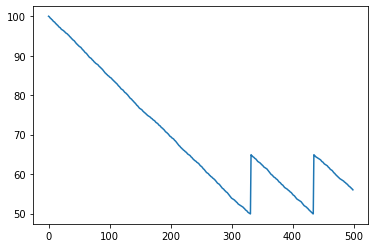

In [84]:
# placeholder to track the SOH over time
vals = np.zeros((steps))

# simulation
for i in range(0, steps):
    if(soh >= 50):
        idx = np.random.randint(1, 3)
    else:
        idx = np.random.randint(0, 3)
    vals[i] = soh
    soh = update_soh(soh, actions[idx])
    state = get_state(soh)
plt.plot(vals)